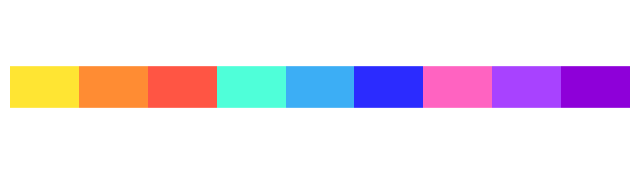

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import numpy as np
import os



def draw_colors(colors):
    # Plot the colors as swatches
    plt.figure(figsize=(8, 2))
    for i, color in enumerate(colors):
        plt.plot([i, i+1], [0, 0], color=color, linewidth=30, solid_capstyle='butt')

    # Remove axes and set display limits
    plt.gca().axis('off')
    plt.xlim(0, len(colors))

    # Show the plot
    plt.show()



new_map = {
    '1, 20000': "#ffe533",  # Slightly warmer yellow
    '1, 50000': "#ff8c33",  # Slightly deeper orange
    '1, 100000': "#ff5544",  # Slightly more vibrant red
    '2, 20000': "#4fffd9",  # Slightly greener turquoise
    '2, 50000': "#3caef5",  # Slightly darker blue
    '2, 100000': "#2b2bff",  # Slightly richer royal blue
    '4, 20000': "#ff63c1",  # Slightly lighter pink
    '4, 50000': "#a842ff",  # Slightly cooler purple
    '4, 100000': "#8e00d9",  # Slightly darker violet
}
files = [
        "../../../data/out_metrics/accuracies_20250124_054532_seq_0_2.pkl",
        "../../../data/out_metrics/accuracies_20250124_203800_seq_1_2.pkl",
        "../../../data/out_metrics/accuracies_20250124_120845_seq_2_4.pkl",
        "../../../data/out_metrics/accuracies_20250124_192504_seq_3_4.pkl",
        "../../../data/out_metrics/accuracies_20250124_095433_seq_4_6.pkl",
        "../../../data/out_metrics/accuracies_20250124_232531_seq_5_6.pkl",
        "../../../data/out_metrics/accuracies_20250124_135938_seq_6_8.pkl",
        "../../../data/out_metrics/accuracies_20250125_061932_seq_7_8.pkl",
        "../../../data/out_metrics/accuracies_20250125_124942_seq_8_10.pkl",
        "../../../data/out_metrics/accuracies_20250126_021304_seq_8_10.pkl",
        "../../../data/out_metrics/accuracies_20250125_062012_seq_10_12.pkl",
        "../../../data/out_metrics/accuracies_20250126_042314_seq_10_12.pkl",
        "../../../data/out_metrics/accuracies_20250126_025138_seq_12_14.pkl",
        "../../../data/out_metrics/accuracies_20250127_220949_seq_14_16.pkl",
        "../../../data/out_metrics/accuracies_20250127_200356_seq_15_16.pkl",
        "../../../data/out_metrics/accuracies_20250126_093419_seq_16_18.pkl",
        ]

draw_colors(new_map.values())

def savefig_and_show(figname):
    plt.savefig(
        figname+".png", format="png", dpi=600
    )
    plt.savefig(
        figname+".pdf", format="pdf"
    )
    plt.show()



IMG_DIR = "../../img"

In [2]:
# !ls ../../../data/out_metrics/accuracies_202501*_seq_0_2.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_1_2.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_2_4.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_3_4.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_4_6.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_5_6.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_6_8.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_7_8.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_8_10.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_10_12.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_12_14.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_14_16.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_15_16.pkl
# !ls ../../../data/out_metrics/accuracies_202501*_seq_16_18.pkl

In [3]:
all_results = dict()
all_caps = dict()
for file_name in files:
    with open(file_name, "rb") as file:
        results = dict(pickle.load(file))
    all_results = {**all_results, **results}
    with open(file_name.replace('accuracies', 'capacities'), "rb") as file:
        results = dict(pickle.load(file))
    all_caps = {**all_caps, **results}
    
print(f"Amount of sets: {len(all_results)}")

# Flatten the data while preserving the structure from the tuple keys
flattened_data = {
    "activation_function": [],
    "num_layers": [],
    "n_rows": [],
    "iteration": [],
    "epochs": [],
    "accuracy": [],
    "capacity": []
}

# Iterate over each dataset size, activation function, and number of layers
for (n_rows, act_fn, n_layers), list_of_iterations in all_results.items():
    # For each iteration in the dataset size
    capacities_list = all_caps[(n_rows, act_fn, n_layers)]
    for i, iteration_list in enumerate(list_of_iterations):
        cur_cap_list = capacities_list[i]
        # Flatten the iteration list with epochs multiplied by 2 (0, 2, 4, ..., 18)
        for epoch, value in enumerate(iteration_list):
            cur_act_fn = act_fn
            if act_fn == 'default':
                cur_act_fn = "default"
            flattened_data["activation_function"].append(cur_act_fn)
            flattened_data["num_layers"].append(n_layers)
            flattened_data["n_rows"].append(n_rows)
            flattened_data["iteration"].append(i)
            flattened_data["epochs"].append((epoch+1))
            flattened_data["accuracy"].append(value)
            flattened_data["capacity"].append(cur_cap_list[epoch])

# Convert to DataFrame for plotting
results_melted = pd.DataFrame(flattened_data)
results_melted.activation_function = results_melted.activation_function.apply(lambda x: {'RReLU':"RReLU", 'softmax':'softmax'}[x])
results_melted
# pd.DataFrame(all_results).T

Amount of sets: 16


,activation_function,num_layers,n_rows,iteration,epochs,accuracy,capacity
0,RReLU,1,20000,0,1,16.852137,6012
1,RReLU,1,20000,0,2,18.127540,6467
2,RReLU,1,20000,0,3,19.627190,7002
3,RReLU,1,20000,0,4,25.496847,9096
4,RReLU,1,20000,0,5,41.236160,14711
...,...,...,...,...,...,...,...
19195,softmax,2,100000,2,396,99.130771,166505
19196,softmax,2,100000,2,397,99.048016,166366
19197,softmax,2,100000,2,398,99.158753,166552
19198,softmax,2,100000,2,399,99.489179,167107


In [4]:
# TO DELETE ONCE RELAUNCH
results_melted['total_n'] = results_melted.capacity/results_melted.accuracy*100
n_to_seq = dict(results_melted.groupby('n_rows').agg({'total_n':'mean'}).round().total_n)
# result_melted['real_seq_n'] = 0
results_melted.capacity = (results_melted.n_rows.apply(lambda x: n_to_seq[int(x)])*results_melted.accuracy/100).round()
results_melted

,activation_function,num_layers,n_rows,iteration,epochs,accuracy,capacity,total_n
0,RReLU,1,20000,0,1,16.852137,5883.0,35675.0
1,RReLU,1,20000,0,2,18.127540,6328.0,35675.0
2,RReLU,1,20000,0,3,19.627190,6851.0,35675.0
3,RReLU,1,20000,0,4,25.496847,8900.0,35675.0
4,RReLU,1,20000,0,5,41.236160,14395.0,35675.0
...,...,...,...,...,...,...,...,...
19195,softmax,2,100000,2,396,99.130771,166505.0,167965.0
19196,softmax,2,100000,2,397,99.048016,166366.0,167965.0
19197,softmax,2,100000,2,398,99.158753,166552.0,167965.0
19198,softmax,2,100000,2,399,99.489179,167107.0,167965.0


In [5]:
def draw_acc_epochs(
    results_melted,
    cur_cutoff,
    layer_color_map,
    yticks=None,
    y_lines=None,  # Specific y level for horizontal line
    x="epochs",
    y="accuracy",
    xlabel="Epochs",
    ylabel="Accuracy, %",
    title="Mean accuracy with standard deviation per epoch of training\nfor different data sizes, activation functions, and layers amount",
):
    cur_results_melted = results_melted[results_melted.epochs <= cur_cutoff].rename(
        columns={
            "n_rows": "data size",
            "n_rows, num_layers": "layers amount, data size",
            "activation_function": "activation function",
        }
    )

    # Plot with Seaborn
    sns.set_style("white", rc={
    'xtick.bottom': True,
    'ytick.left': True,
    })

    plt.figure(figsize=(9, 5))
    
    
    if y_lines is not None:
        for y_line in y_lines:
            plt.axhline(
                y=y_line,
                color="black",
                alpha=0.9,
                linestyle="--",
                linewidth=0.9,   
            )

    sns.lineplot(
        data=cur_results_melted,
        x=x,
        y=y,
        hue="layers amount, data size",  # Combined hue for Num_Layers and N_rows
        style="activation function",
        palette=layer_color_map,  # Ensure this supports the combined categories
        linewidth=1,
    )

    plt.xlim(0, cur_cutoff)

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Experiment 4:", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    sns.despine(offset=2)
    # Optionally add yticks
    if yticks is not None:
        plt.yticks(yticks)  # Custom y-ticks
        
    # Show the plot
    plt.tight_layout()

In [6]:
# Generate unique colors for each Num_Layers value
unique_layers = results_melted['num_layers'].unique()
layer_palette = sns.color_palette("Set2", len(unique_layers))
layer_color_map = {layer: color for layer, color in zip(unique_layers, layer_palette)}

results_melted['n_rows, num_layers'] = results_melted['num_layers'].astype(str) + ", " + results_melted['n_rows'].astype(str)  
unique_hues = sorted(results_melted['n_rows, num_layers'].unique())
layer_color_map = {hue: sns.color_palette("Paired")[i % 10] for i, hue in enumerate(unique_hues)}


30


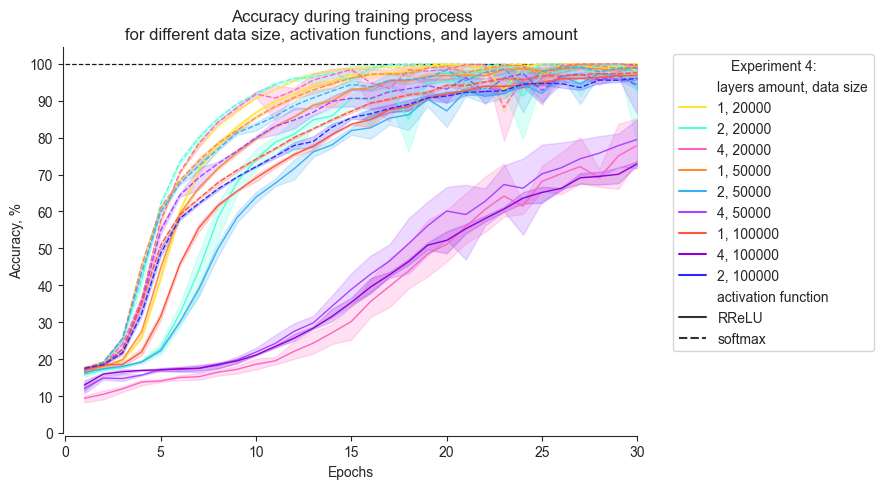

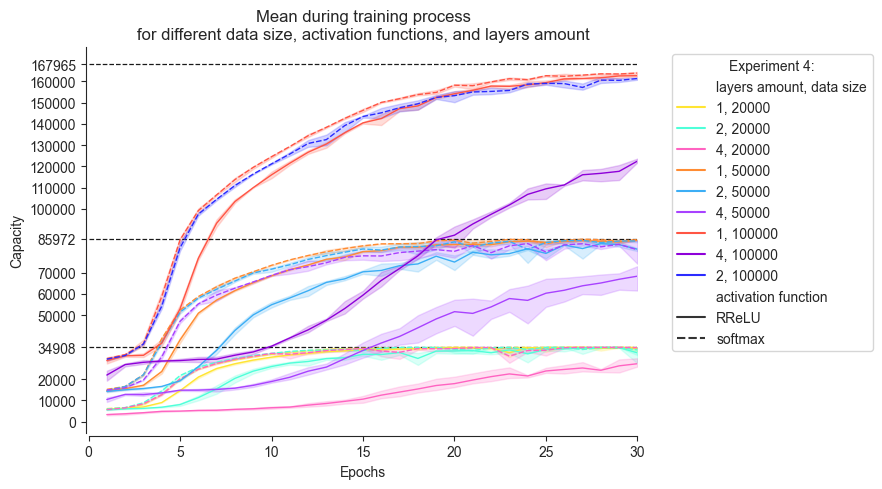

100


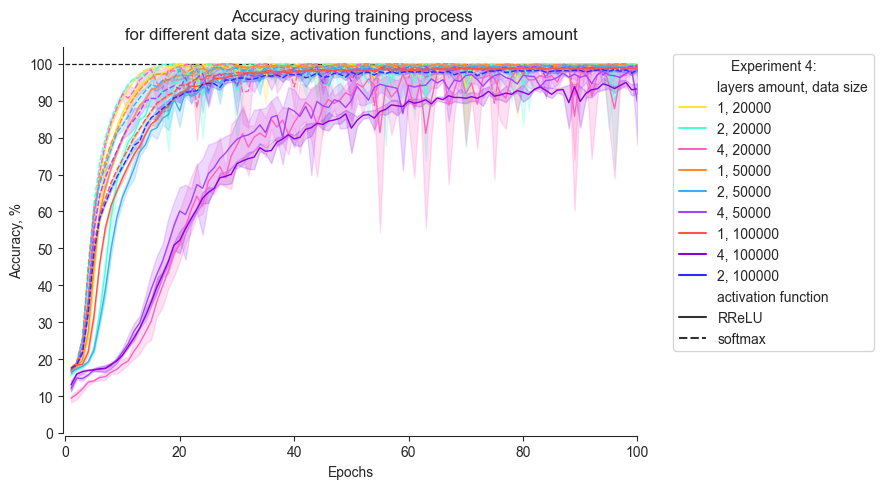

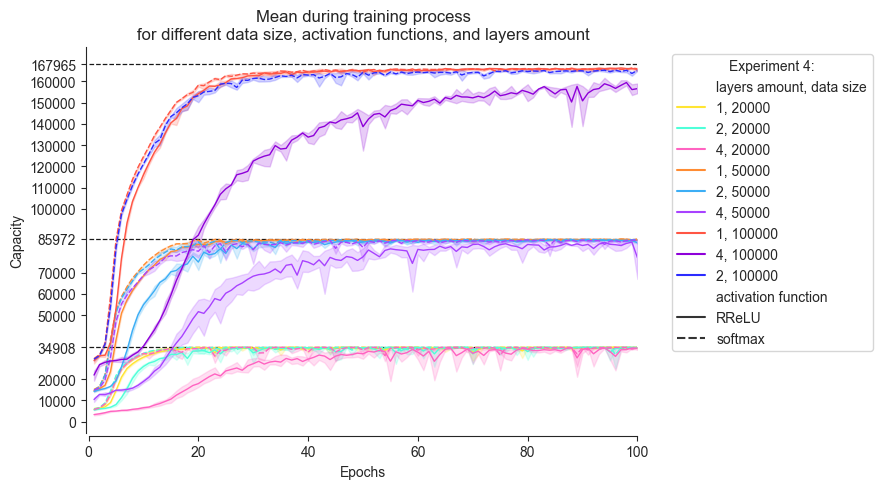

400


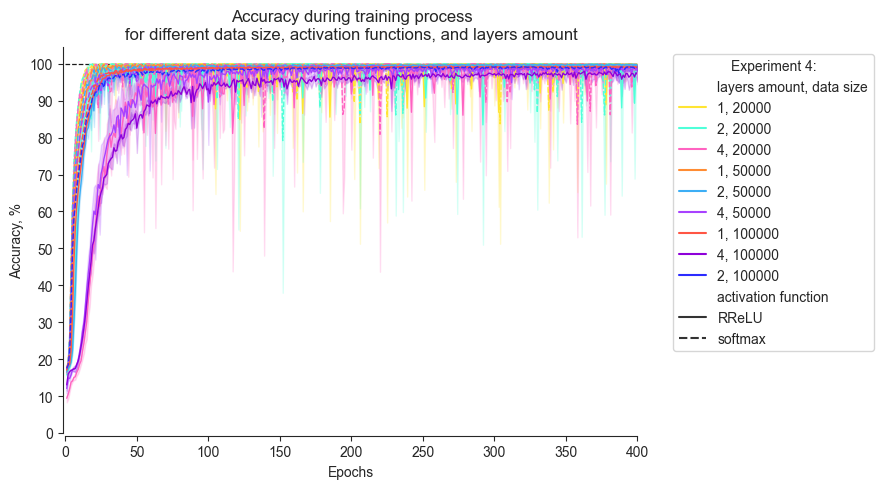

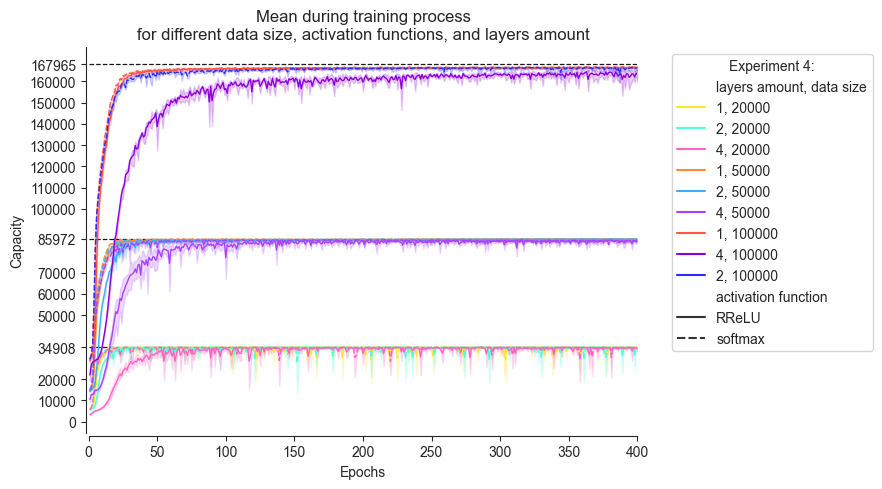

In [7]:
n_seqs = [int(i) for i in n_to_seq.values()]

for epochs in [30, 100, results_melted.epochs.max()]:
    print(epochs)
    draw_acc_epochs(
        results_melted,
        epochs,
        new_map,
        yticks=np.arange(0, 101, 10),
        y_lines=[100,],
        x="epochs",
        y="accuracy",
        xlabel="Epochs",
        ylabel="Accuracy, %",
        title="Accuracy during training process\nfor different data size, activation functions, and layers amount",
    )
    savefig_and_show(os.path.join(IMG_DIR, f"4_seqs_acc_{epochs}"))
    draw_acc_epochs(
        results_melted,
        epochs,
        new_map,
        yticks=list(set(range(0, 170001, 10000))-set([170000,80000,90000,30000,40000]) | set(n_seqs)),
        y_lines=n_to_seq.values(),
        x="epochs",
        y="capacity",
        xlabel="Epochs",
        ylabel="Capacity",
        title="Mean during training process\nfor different data size, activation functions, and layers amount",
    )
    savefig_and_show(os.path.join(IMG_DIR, f"4_seqs_cap_{epochs}"))

## Violins

In [8]:
data_viol = results_melted[results_melted.epochs == max(results_melted.epochs)]
data_viol = results_melted.groupby(['activation_function','num_layers','n_rows', 'iteration']).agg({'accuracy':'max', 'capacity':'max'}).reset_index()
print(data_viol.shape)
data_viol.head()

(48, 6)


,activation_function,num_layers,n_rows,iteration,accuracy,capacity
0,RReLU,1,20000,0,100.000000,34908.0
1,RReLU,1,20000,1,100.000000,34908.0
2,RReLU,1,20000,2,100.000000,34908.0
3,RReLU,1,50000,0,99.944269,85924.0
4,RReLU,1,50000,1,99.950838,85930.0


In [9]:
temp = deepcopy(data_viol)
temp.activation_function = 'all'

df = pd.concat([data_viol, temp]).set_index(['activation_function','num_layers'])[['n_rows', 'accuracy', 'capacity']]
grouped = (
    df.groupby(['activation_function', 'num_layers', 'n_rows'])
    .agg(accuracy_mean=('accuracy', 'mean'),
         accuracy_std=('accuracy', 'std'),
         capacity_mean=('capacity', 'mean'),
         capacity_std=('capacity', 'std'))
)

# Unstack to pivot `n_rows` into columns
final = grouped.unstack(level='n_rows')

# Create a MultiIndex for columns with the correct order
final.columns = pd.MultiIndex.from_tuples(
    [(n_rows, metric) for metric, n_rows in final.columns],
    names=["n_rows", "metric"]
)
# ORDER cols
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]

# ORDER rows
# Define the desired order for 'activation_function'
activation_order = ['RReLU', 'softmax', 'all']

# Reorder rows based on the activation function order
final = final.loc[activation_order]

# Rearrange columns: first all related to 50000, then 70000
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]


final

n_rows                                20000                              \
metric                         accuracy_mean accuracy_std capacity_mean   
activation_function num_layers                                            
RReLU               1                  100.0          0.0       34908.0   
                    2                  100.0          0.0       34908.0   
                    4                  100.0          0.0       34908.0   
softmax             1                  100.0          0.0       34908.0   
                    2                  100.0          0.0       34908.0   
                    4                  100.0          0.0       34908.0   
all                 1                  100.0          0.0       34908.0   
                    2                  100.0          0.0       34908.0   
                    4                  100.0          0.0       34908.0   

n_rows                                             50000                \
metric                         capacity_std accuracy_mean accuracy_std   
activation_function num_layers                                           
RReLU               1                   0.0     99.957594     0.017698   
                    2                   0.0     99.936278     0.019281   
                    4                   0.0     99.621810     0.157376   
softmax             1                   0.0     99.952298     0.010635   
                    2                   0.0     99.903038     0.019202   
                    4                   0.0     99.766546     0.024575   
all                 1                   0.0     99.954946     0.013377   
                    2                   0.0     99.919658     0.025053   
                    4                   0.0     99.694178     0.128191   

n_rows                                                           100000  \
metric                         capacity_mean capacity_std accuracy_mean   
activation_function num_layers                                            
RReLU               1           85935.666667    15.307950     99.385983   
                    2           85917.333333    17.009801           NaN   
                    4           85647.000000   135.014814     98.395896   
softmax             1           85931.333333     9.073772     99.420911   
                    2           85888.333333    16.441817     99.416545   
                    4           85771.333333    21.079216           NaN   
all                 1           85933.500000    11.502174     99.403447   
                    2           85902.833333    21.821243     99.416545   
                    4           85709.166667   110.031662     98.395896   

n_rows                                                                   
metric                         accuracy_std  capacity_mean capacity_std  
activation_function num_layers                                           
RReLU               1              0.072285  166933.666667   121.413893  
                    2                   NaN            NaN          NaN  
                    4              0.317869  165270.666667   533.908544  
softmax             1              0.032611  166992.333333    54.775299  
                    2              0.269044  166985.000000   451.899325  
                    4                   NaN            NaN          NaN  
all                 1              0.053679  166963.000000    90.162076  
                    2              0.269044  166985.000000   451.899325  
                    4              0.317869  165270.666667   533.908544

In [10]:
def draw_violins(
    data_viol, x, y, xlabel, ylabel, title, hue=None, return_ax=False, ax=None
):
    PALETTE_PARAMS = "Accent"
    PALETTE = "Set2"
    data_dict = {
        "x": x,
        "y": y,
        "palette": list(new_map.values())[::3],
        "alpha": 0.7,
        "linewidth": 0.5,
    }
    if hue:
        data_dict["hue"] = hue
        data_dict["dodge"] = True
    if ax:
        data_dict["ax"] = axs[col]
    ax = sns.stripplot(data_viol, **data_dict, legend=True)
    ax = sns.violinplot(
        data_viol,
        **data_dict,
        cut=0,
        legend=False,
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if return_ax:
        return ax

All together


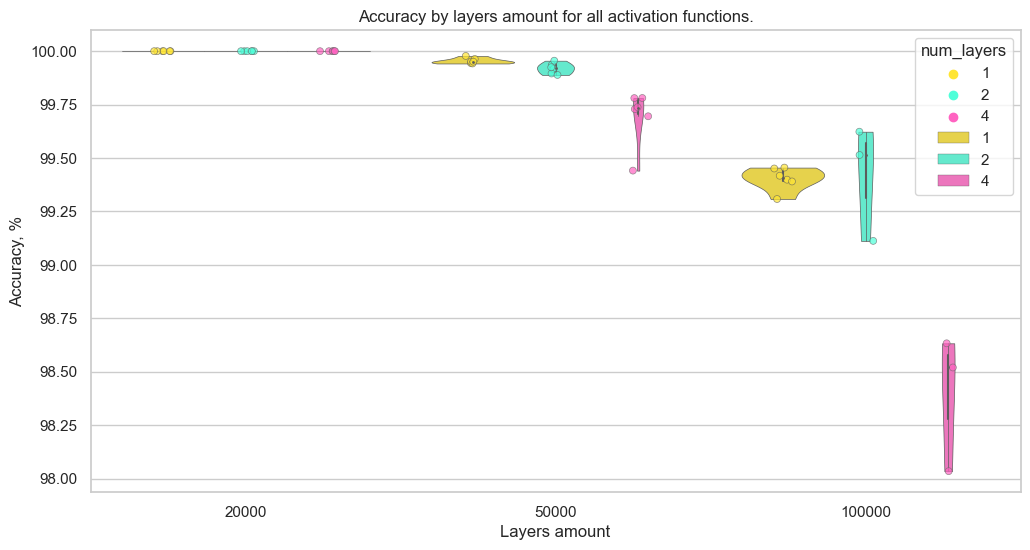

Separated


<Figure size 1400x400 with 0 Axes>

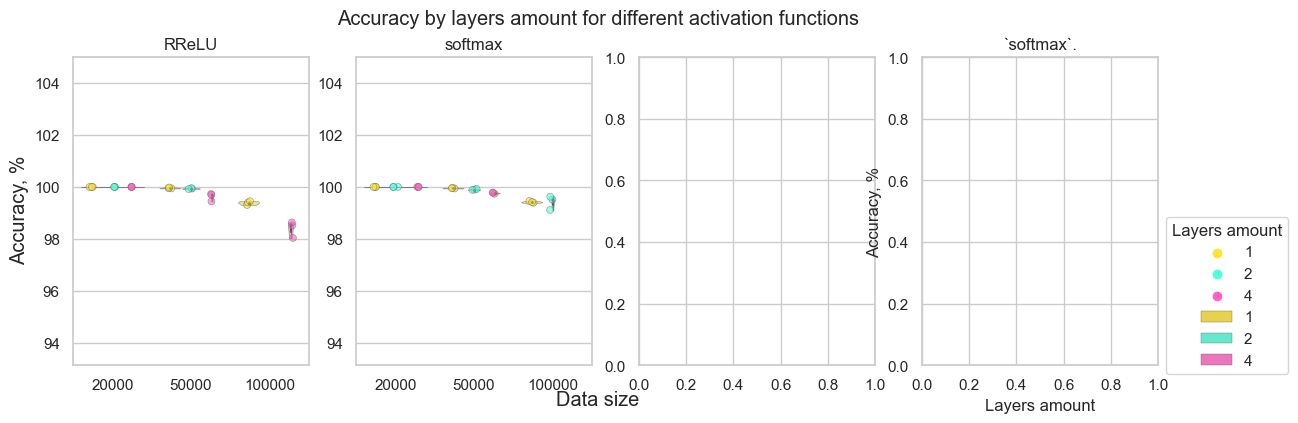

All together


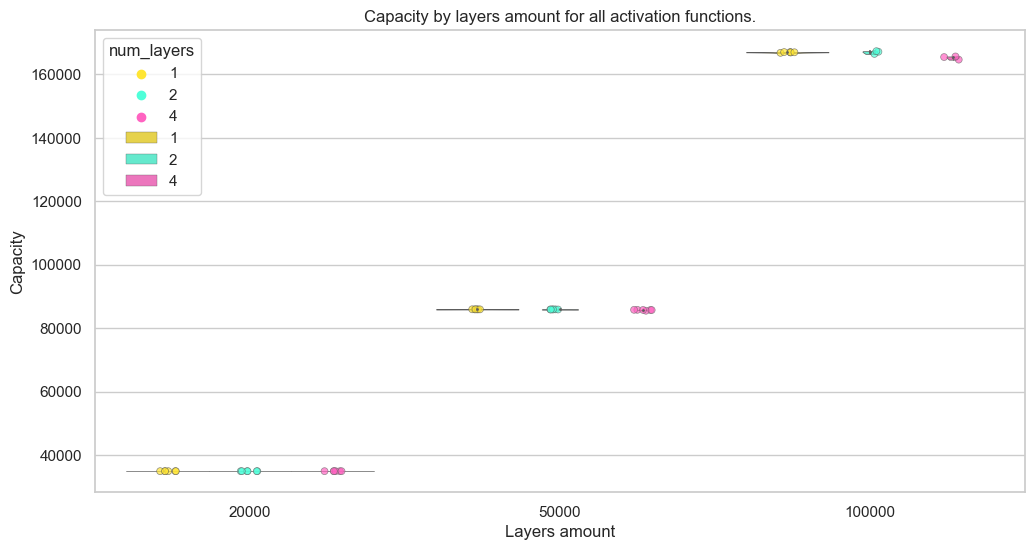

Separated


<Figure size 1400x400 with 0 Axes>

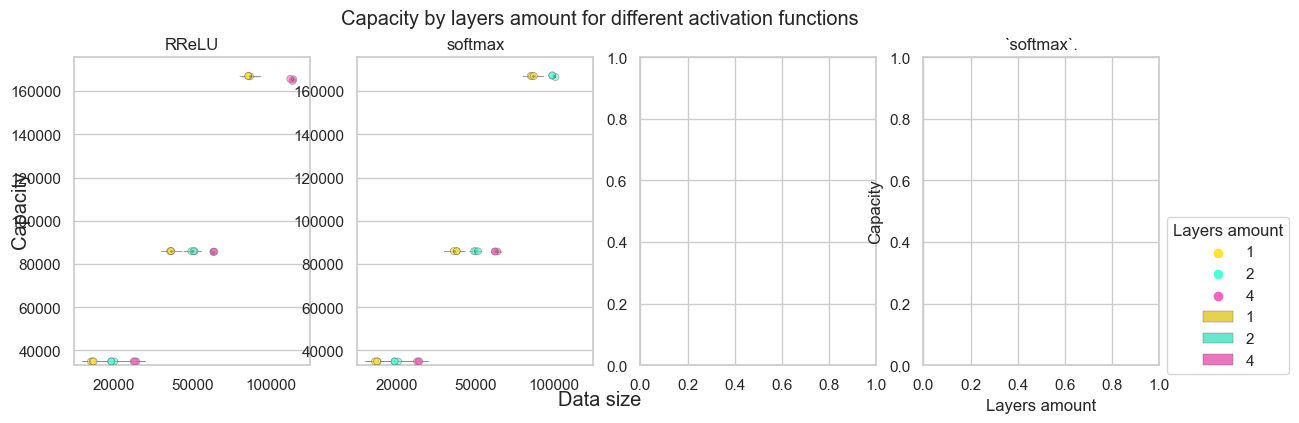

In [11]:
labels = [
    (
        "accuracy",
        "Accuracy, %",
        "Accuracy by layers amount for all activation functions.",
        "Accuracy by layers amount for different activation functions",
        (0, 100)
    ),
    (
        "capacity",
        "Capacity",
        "Capacity by layers amount for all activation functions.",
        "Capacity by layers amount for different activation functions",
        (0, 100000)
    ),
]


for y, ylabel, title, title_separated, val_range in labels:
    print("All together")
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    draw_violins(
        data_viol,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=title,
        hue="num_layers",
    )
    plt.show()
    # ==================================================
    print("Separated")
    sns.set(rc={"figure.figsize": (14, 4)})
    sns.set_theme(style="whitegrid")
    # get legend
    ax = draw_violins(
        data_viol,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=title_separated,
        hue="num_layers",
        return_ax=True,
    )
    handles, labels = ax.get_legend_handles_labels()
    plt.clf()
    # draw
    fig, axs = plt.subplots(nrows=1, ncols=4)
    for i, act_f in enumerate(data_viol.activation_function.unique()):
        row = i // 4
        col = i % 4
        cur_data = data_viol[data_viol.activation_function == act_f]
        ax = draw_violins(
            cur_data,
            x="n_rows",
            y=y,
            xlabel="Layers amount",
            ylabel=ylabel,
            title=f"`{act_f}`.",
            hue="num_layers",
            return_ax=True,
            ax=axs[col],
        )
        plt.setp(ax.collections, alpha=0.58)
        ax.legend_.remove()
        ax.set(ylabel="", xlabel="", title=act_f)
        ax.set(ylim=(data_viol[y].min()*0.95, data_viol[y].max()*1.05))
        ax
    fig.supylabel(ylabel, y=0.5, x=0.08)
    fig.supxlabel("Data size", y=0, x=0.5)
    fig.suptitle(title_separated, y=1, x=0.5)
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.9, 0.5),
        title="Layers amount",
    )
    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2
    )
    plt.show()